# NLP - spam detection

In [1]:
# 통합코드

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


# 데이터 로드
df = pd.read_csv('spam.csv', encoding='latin1')

df_choose = df[["v1", "v2"]]

df_choose = df_choose.rename(columns={'v1': 'label', 'v2': 'text'})

# 'text' 컬럼 전처리
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # 소문자로 변환
    text = text.lower()
    # 특수 문자와 숫자 제거
    text = re.sub(r'[^a-z\s]', '', text)
    # 불필요한 공백 제거
    text = re.sub(r'\s+', ' ', text).strip()
    # 표제어 추출 및 불용어 제거
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]
    return ' '.join(words)

df_choose['text'] = df_choose['text'].apply(preprocess_text)

# 레이블 인코딩
label_encoder = LabelEncoder()
df_choose['label'] = label_encoder.fit_transform(df_choose['label'])

# 학습 및 테스트 데이터 분리
X = df_choose['text'].values
Y = df_choose['label'].values
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# 토큰화 및 시퀀스 패딩
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

X_train_sequences = tokenizer.texts_to_sequences(X_train)
X_test_sequences = tokenizer.texts_to_sequences(X_test)

/Users/hong/venvs/nlp_env/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
print(label_encoder.classes_)
print(label_encoder.transform(['ham', 'spam']))


['ham' 'spam']
[0 1]


=== 문장 길이 분석 ===
평균 길이: 8.86
중간값: 7.0
최소 길이: 0
최대 길이: 70
95% 백분위: 20
99% 백분위: 29


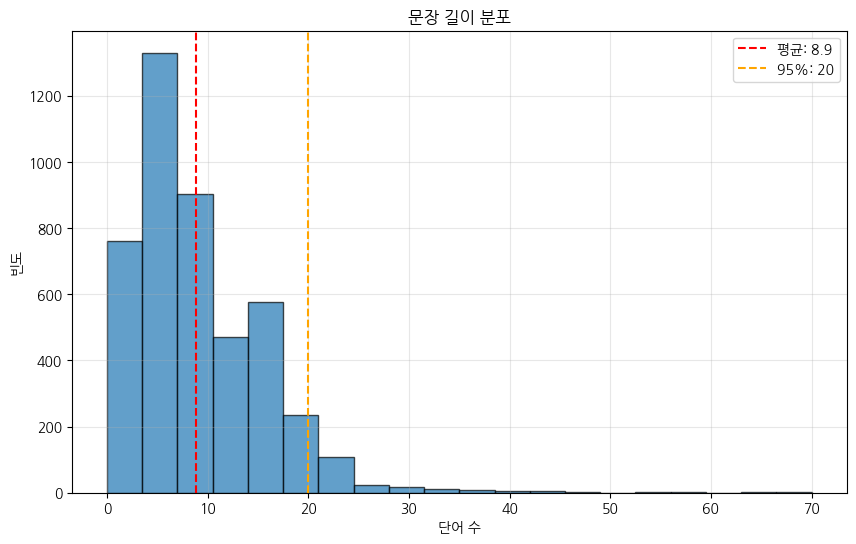


=== max_len 옵션 ===
옵션 1 (최댓값): 70 - 모든 문장 보존, 메모리 많이 사용
옵션 2 (95%): 20 - 5% 문장 잘림, 메모리 효율적
옵션 3 (99%): 29 - 1% 문장 잘림, 균형

선택된 max_len: 20
최종 shape - X_train: (4457, 20), X_test: (1115, 20)


In [3]:
import koreanize_matplotlib

print("=== 문장 길이 분석 ===")
lengths = [len(seq) for seq in X_train_sequences]

print(f"평균 길이: {np.mean(lengths):.2f}")
print(f"중간값: {np.median(lengths):.1f}")
print(f"최소 길이: {min(lengths)}")
print(f"최대 길이: {max(lengths)}")
print(f"95% 백분위: {np.percentile(lengths, 95):.0f}")
print(f"99% 백분위: {np.percentile(lengths, 99):.0f}")

# 길이 분포 시각화
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(lengths, bins=20, alpha=0.7, edgecolor='black')
plt.title('문장 길이 분포')
plt.xlabel('단어 수')
plt.ylabel('빈도')
plt.axvline(np.mean(lengths), color='red', linestyle='--', label=f'평균: {np.mean(lengths):.1f}')
plt.axvline(np.percentile(lengths, 95), color='orange', linestyle='--', label=f'95%: {np.percentile(lengths, 95):.0f}')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# max_len 결정
print("\n=== max_len 옵션 ===")
option1 = max(lengths)  # 현재 방식
option2 = int(np.percentile(lengths, 95))  # 95% 커버
option3 = int(np.percentile(lengths, 99))  # 99% 커버

print(f"옵션 1 (최댓값): {option1} - 모든 문장 보존, 메모리 많이 사용")
print(f"옵션 2 (95%): {option2} - 5% 문장 잘림, 메모리 효율적")
print(f"옵션 3 (99%): {option3} - 1% 문장 잘림, 균형")

# 선택한 max_len 적용
max_len = option2  # 또는 option1, option3 중 선택

print(f"\n선택된 max_len: {max_len}")


# 패딩 적용

X_train = pad_sequences(X_train_sequences, maxlen=max_len)
X_test = pad_sequences(X_test_sequences, maxlen=max_len)

print(f"최종 shape - X_train: {X_train.shape}, X_test: {X_test.shape}")

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Embedding,
    Dropout,
    Dense,
    Flatten,
    GlobalAveragePooling1D,
    LSTM
)

# DNN 모델 구성 ( Flatten 사용)

model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=128))
model.add(Dropout(0.2))
model.add(LSTM(128))  # LSTM의 출력이 2D로 자동 변환되어 Dense에 입력
model.add(Dense(512, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(256, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.2))
model.add(Dense(1, activation="sigmoid"))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))

# 학습 완료 후 모델을 HDF5 형식으로 저장
model.save('spam_detection_model.h5')

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.8587 - loss: 0.3696 - val_accuracy: 0.9767 - val_loss: 0.0714
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.9875 - loss: 0.0409 - val_accuracy: 0.9794 - val_loss: 0.0793
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 0.9970 - loss: 0.0081 - val_accuracy: 0.9767 - val_loss: 0.0964
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9977 - loss: 0.0067 - val_accuracy: 0.9785 - val_loss: 0.1120
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 0.0011 - val_accuracy: 0.9803 - val_loss: 0.1589
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - accuracy: 1.0000 - loss: 4.7725e-05 - val_accuracy: 0.9803 - val_loss: 0.1660
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 3.5155e-05 - val_accuracy: 0.9785 - val_loss: 0.1808
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 1.0000 - loss: 2.9637e-05 - val_accuracy

In [12]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# 이진분류 예측 및 평가
y_pred = model.predict(X_test)

# y_pred와 y_test의 shape 확인
print(f"y_pred shape: {y_pred.shape}")
print(f"y_test shape: {y_test.shape}")

# y_pred 처리 (sigmoid 출력이므로 0.5 threshold 사용)
y_pred_classes = (y_pred > 0.5).astype(int).flatten()

# y_test는 이미 binary 형태이므로 그대로 사용
y_test_classes = y_test  # 이미 [0, 1, 0, 1, ...] 형태

# shape 확인
print(f"y_pred_classes shape: {y_pred_classes.shape}")
print(f"y_test_classes shape: {y_test_classes.shape}")

# 평가
accuracy = accuracy_score(y_test_classes, y_pred_classes)
report = classification_report(y_test_classes, y_pred_classes, target_names=['ham', 'spam'])

print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", report)

35/35 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
y_pred shape: (1115, 1)
y_test shape: (1115,)
y_pred_classes shape: (1115,)
y_test_classes shape: (1115,)
Accuracy: 0.9803
Classification Report:
               precision    recall  f1-score   support

         ham       0.98      0.99      0.99       965
        spam       0.96      0.89      0.92       150

    accuracy                           0.98      1115
   macro avg       0.97      0.94      0.96      1115
weighted avg       0.98      0.98      0.98      1115



In [15]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 기존에 사용했던 변수들 (전처리 함수와 tokenizer, max_len)은 이미 정의되어 있다고 가정

# 1. 저장된 모델 불러오기
try:
    model = load_model('spam_detection_model.h5')
    print("모델을 성공적으로 불러왔습니다.")
except Exception as e:
    print(f"모델을 불러오는 중 오류가 발생했습니다: {e}")
    print("모델 파일(spam_detection_model.h5)이 현재 디렉터리에 있는지 확인해 주세요.")

# 2. 사용자 입력 받아 예측하기
while True:
    input_text = input("문장을 입력하세요 (종료하려면 '종료'를 입력): ")

    if input_text == '종료':
        print("프로그램을 종료합니다.")
        break
    
    # 입력 문장 전처리 (기존 함수 재사용)
    preprocessed_sentence = preprocess_text(input_text)
    sequences = tokenizer.texts_to_sequences([preprocessed_sentence])
    padded_sequences = pad_sequences(sequences, maxlen=max_len)

    # 예측
    prediction = model.predict(padded_sequences, verbose=0)
    
    # 클래스 이름 정의
    class_names = ["ham", "spam"]
    
    # 예측 결과 처리
    prob = prediction[0][0]
    predicted_class_idx = int(prob > 0.5)
    confidence = prob if predicted_class_idx == 1 else 1 - prob
    predicted_class = class_names[predicted_class_idx]
    
    print("-" * 30)
    print(f"입력 문장: {input_text}")
    print(f"예측 결과: {predicted_class} (신뢰도: {confidence:.2f})")
    print(f"확률값 (spam): {prob:.4f}")
    print("-" * 30)

모델을 성공적으로 불러왔습니다.
------------------------------
입력 문장: Think ur smart ? Win �200 this week in our weekly quiz, text PLAY to 85222 now!T&Cs WinnersClub PO BOX 84, M26 3UZ. 16+. GBP1.50/week
예측 결과: spam (신뢰도: 1.00)
확률값 (spam): 1.0000
------------------------------
------------------------------
입력 문장: Think ur smart ? Win �200 this week in our weekly quiz, text PLAY to 85222 now!
예측 결과: spam (신뢰도: 1.00)
확률값 (spam): 1.0000
------------------------------
------------------------------
입력 문장: Think ur smart ? Win �200 this week in our weekly quiz,
예측 결과: spam (신뢰도: 1.00)
확률값 (spam): 1.0000
------------------------------
------------------------------
입력 문장: Think ur smart ? Win �200
예측 결과: ham (신뢰도: 1.00)
확률값 (spam): 0.0026
------------------------------
프로그램을 종료합니다.
